In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
# Loading camera calibration
cameraCalibration = pickle.load( open('./camera_output/camera_calibration.p', 'rb' ) )
mtx, dist = map(cameraCalibration.get, ('mtx', 'dist'))

In [3]:
# Load test images.
testImages = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), 
                      glob.glob('./test_images/*.jpg')))

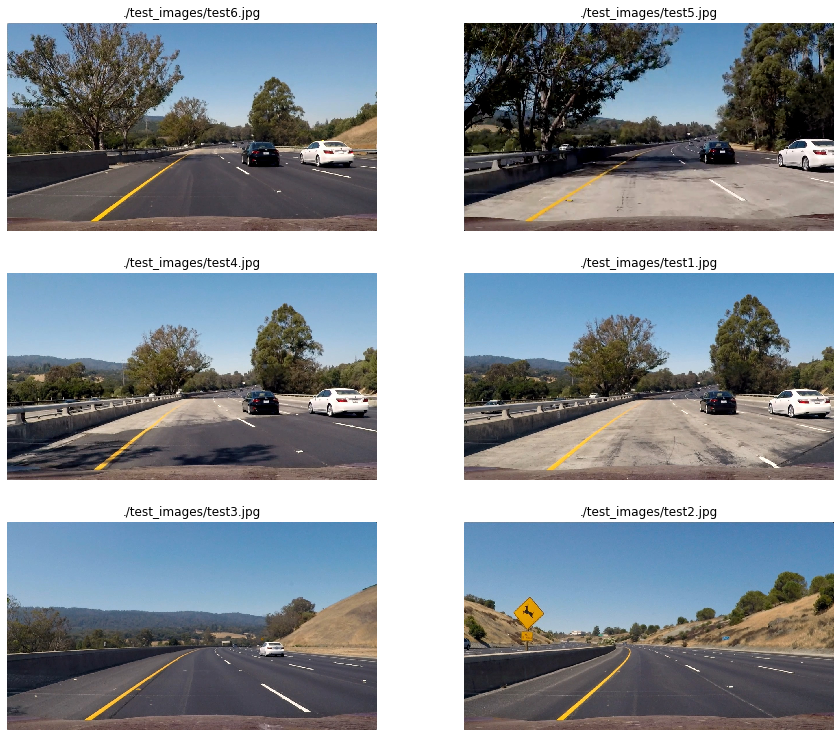

In [4]:
def showImages(images, cols = 4, rows = 5, figsize=(15,10), cmap = None):
    """
    Display `images` on a [`cols`, `rows`] subplot grid.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            if cmap == None:
                ax.imshow(image)
            else:
                ax.imshow(image, cmap=cmap)
            ax.set_title(imagePathName)
            ax.axis('off')
        
showImages(list(map(lambda img: (img[0], cv2.cvtColor(img[1], cv2.COLOR_BGR2RGB)),testImages)), 2, 3, (15, 13))

In [5]:
index = 2
original = testImages[index][1]

In [6]:
def undistortAndHLS(image, mtx=mtx, dist=dist):
    """
    Undistort the image with `mtx`, `dist` and convert it to HLS.
    """
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    return cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)

hlsOriginal = undistortAndHLS(original)

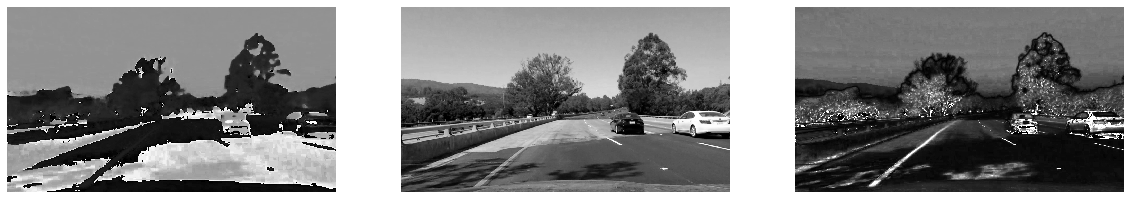

In [7]:
fig, axes = plt.subplots(ncols=3, figsize=(20,10))
for index, a in enumerate(axes):
    a.imshow(hlsOriginal[:,:,index], cmap='gray')
    a.axis('off')

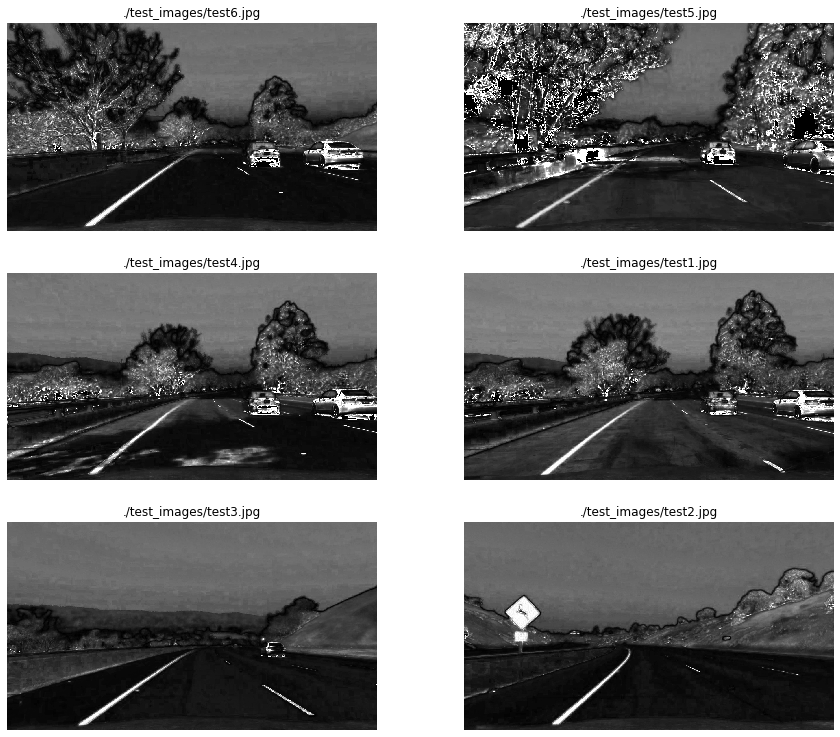

In [8]:
def applyAndPack(images, action):
    """
    Images is a colletion of pairs (`title`, image). This function applies `action` to the image part of `images`
    and pack the pair again to form (`title`, `action`(image)).
    """
    return list(map(lambda img: (img[0], action(img[1])), images))

def applyAndShow(images, action):
    """
    Applies `action` to the pair collection `images` (`title`, image) show the images and titles and return
    (`title`, `action`(image))
    """
    output = applyAndPack(images, action)
    showImages( output, 2, 3, (15, 13), cmap='gray')
    return output
    
useSChannel = lambda img: undistortAndHLS(img)[:,:,2]

resultSChannel = applyAndShow(testImages, useSChannel)

In [9]:
def threshIt(img, thresh_min, thresh_max):
    """
    Applies a threshold to the `img` using [`thresh_min`, `thresh_max`] returning a binary image [0, 255]
    """
    xbinary = np.zeros_like(img)
    xbinary[(img >= thresh_min) & (img <= thresh_max)] = 1
    return xbinary
    
def absSobelThresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    """
    Calculate the Sobel gradient on the direction `orient` and return a binary thresholded image 
    on [`thresh_min`, `thresh_max`]. Using `sobel_kernel` as Sobel kernel size.
    """
    if orient == 'x':
        yorder = 0
        xorder = 1
    else:
        yorder = 1
        xorder = 0
        
    sobel = cv2.Sobel(img, cv2.CV_64F, xorder, yorder, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255.0*abs_sobel/np.max(abs_sobel))
    return threshIt(scaled, thresh_min, thresh_max)

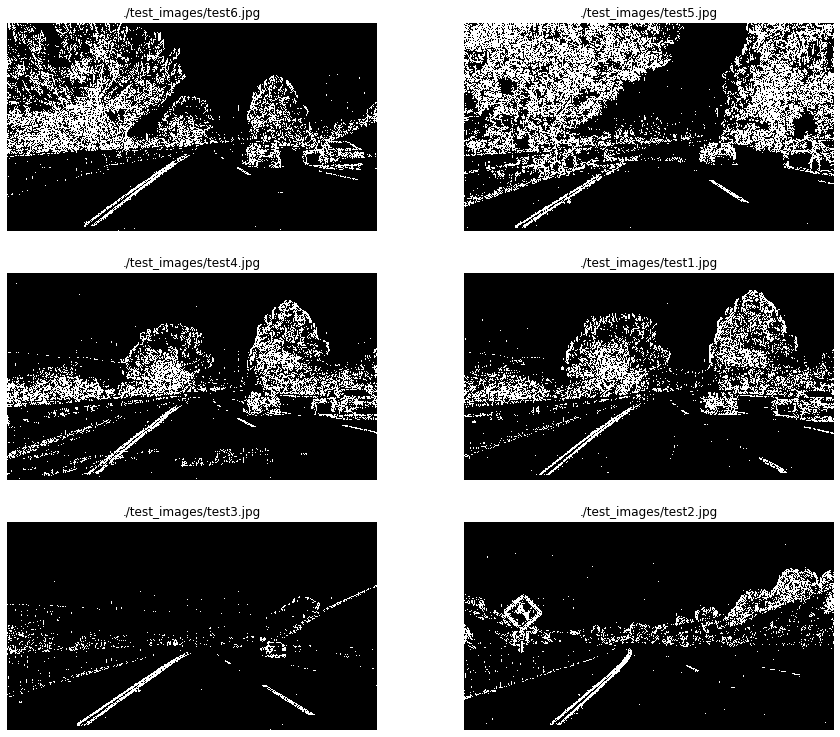

In [10]:
withSobelX = lambda img: absSobelThresh(useSChannel(img), thresh_min=10, thresh_max=160)

resultSobelX = applyAndShow(testImages, withSobelX)

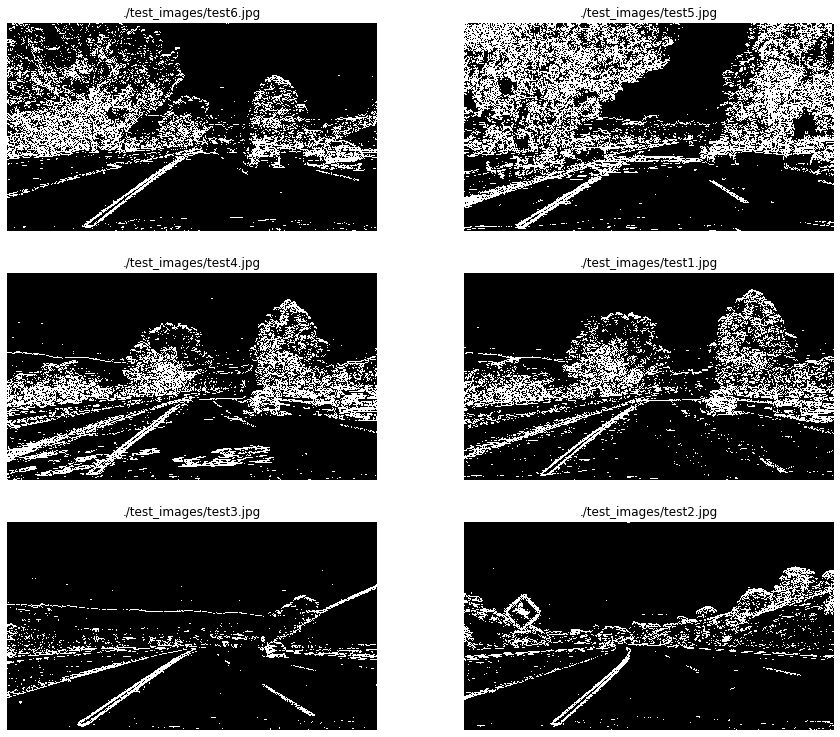

In [11]:
withSobelY = lambda img: absSobelThresh(useSChannel(img), orient='y', thresh_min=10, thresh_max=160)

resultSobelY = applyAndShow(testImages, withSobelY)

In [12]:
def magThresh(img, sobel_kernel=3, thresh_min=0, thresh_max=255):
    """
    Calculate the Sobel magnitude gradient and return a binary thresholded image 
    on [`thresh_min`, `thresh_max`]. Using `sobel_kernel` as Sobel kernel size.
    """
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    return threshIt(gradmag, thresh_min, thresh_max)

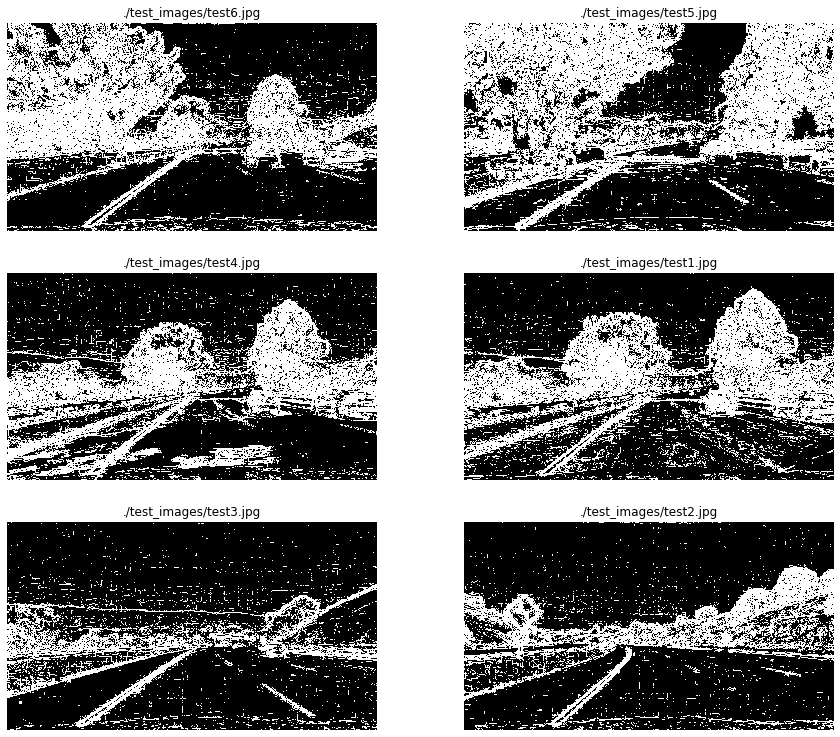

In [13]:
withMagnitude = lambda img: magThresh(useSChannel(img), thresh_min=5, thresh_max=160)

resultMagnitude = applyAndShow(testImages, withMagnitude)

In [14]:
def dirThresh(img, sobel_kernel=3, thresh_min=0, thresh_max=np.pi/2):
    """
    Calculate the Sobel direction gradient and return a binary thresholded image 
    on [`thresh_min`, `thresh_max`]. Using `sobel_kernel` as Sobel kernel size.
    """
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    return threshIt(absgraddir, thresh_min, thresh_max)

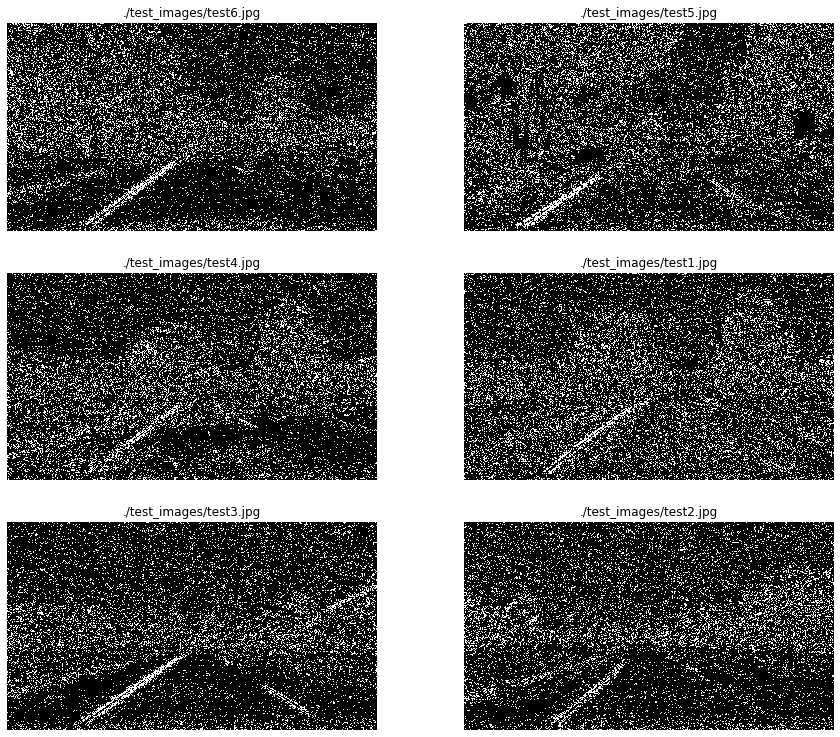

In [15]:
withDirection = lambda img: dirThresh(useSChannel(img), thresh_min=0.79, thresh_max=1.20)

resultDirection = applyAndShow(testImages, withDirection)

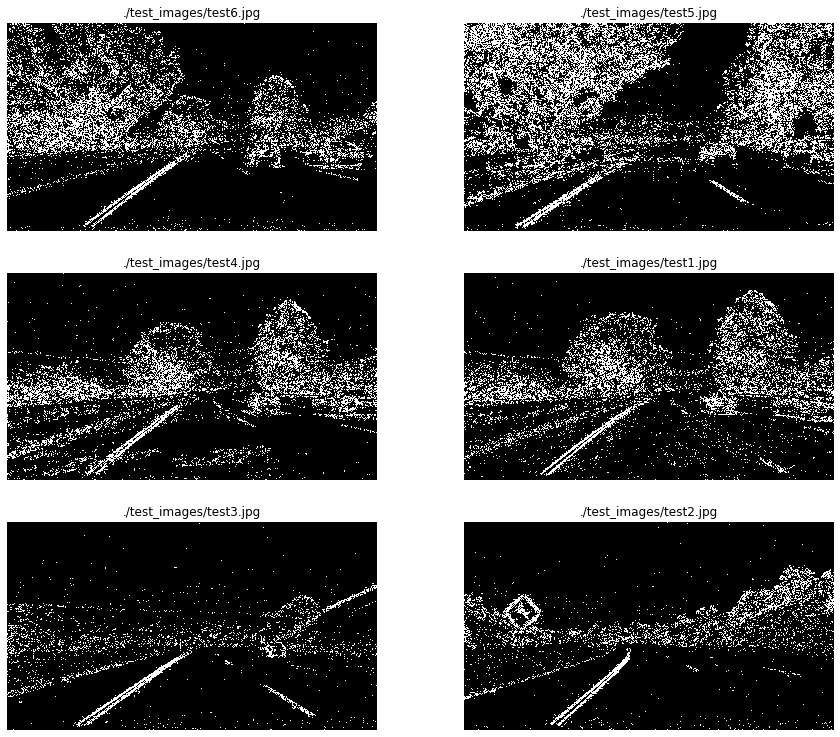

In [16]:
def combineGradients(img):
    """
    Compute the combination of Sobel X and Sobel Y or Magnitude and Direction
    """
    sobelX = withSobelX(img)
    sobelY = withSobelY(img)
    mag = withMagnitude(img)
    direction = withDirection(img)
    combined = np.zeros_like(sobelX) 
    combined[((sobelX == 1) & (sobelY == 1)) | ((mag == 1) & (direction == 1))] = 1
    return combined

resultCombined = applyAndShow(testImages, combineGradients)

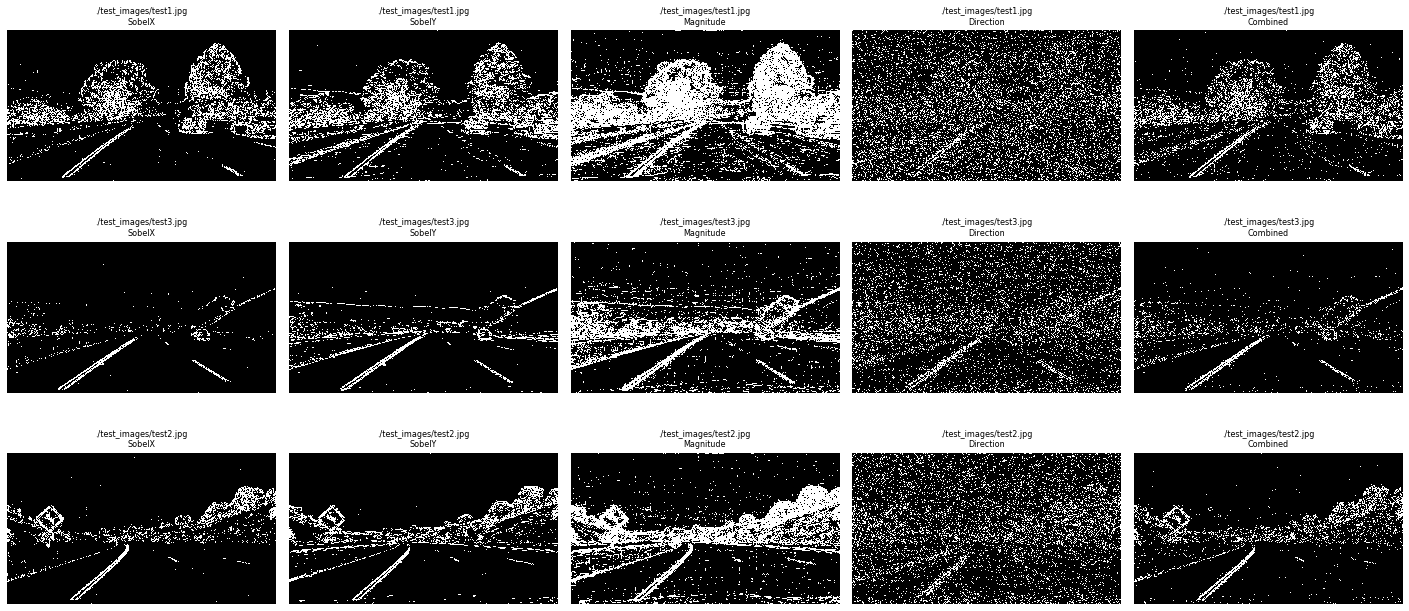

In [17]:
titles = ['SobelX', 'SobelY', 'Magnitude', 'Direction', 'Combined']
results = list(zip( resultSobelX, resultSobelY, resultMagnitude, resultDirection, resultCombined ))
resultsAndTitle = list(map(lambda images: list(zip(titles, images)), results))[3:6]
flattenResults = [item for sublist in resultsAndTitle for item in sublist]

fig, axes = plt.subplots(ncols=5, nrows=len(resultsAndTitle), figsize=(25,10))
for ax, imageTuple in zip(axes.flat, flattenResults):
    title, images = imageTuple
    imagePath, img = images
    ax.imshow(img, cmap='gray')
    ax.set_title(imagePath + '\n' + title, fontsize=8)
    ax.axis('off')
fig.subplots_adjust(hspace=0, wspace=0.05, bottom=0)